# QC protocol for Private Weather Stations

This notebook presents how to use the Python package `pypwsqc`, a quality assurance protocol developed for automated private weather stations (PWS).
The protocol consists of three filters from de Vos et al (2019) the Faulty Zero filter, the High Influx filter and the Station Outlier filter as well as the Indicator Correlation Filter (IC) from Bardossy et al. (2021) 



Publications: 
* de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. Geophysical Research Letters, 46(15), 8820-8829 with original R code at available at https://github.com/LottedeVos/PWSQC/.
* Bárdossy, A., Seidel, J., and El Hachem, A.: The use of personal weather station observations to improve precipitation estimation and interpolation, Hydrol. Earth Syst. Sci., 25, 583–601, https://doi.org/10.5194/hess-25-583-2021, 2021. 



In [63]:
import matplotlib.pyplot as plt
import poligrain as plg
import xarray as xr
from tqdm import tqdm

import pypwsqc

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

## Download example data

In this example, we use an open PWS dataset from Amsterdam, called the "AMS PWS" dataset and a reference built from radar data. By running the cell below, the NetCDF-files will be downloaded to your current repository (if your machine is connected to the internet).

In [2]:
import os
if not os.path.exists("data/"):
    os.makedirs("data/")

In [ ]:
!curl -L https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc > data/OpenSense_PWS_example_format_data.nc


## Data preparations

This package handles rainfall data as `xarray`  Datasets. The data set must have `time` and `id` dimensions, `latitude` and `longitude` as coordinates, and `rainfall` as data variable.

An example of how to convert .csv data to a `xarray` dataset is found [here](https://github.com/OpenSenseAction/OS_data_format_conventions/blob/main/notebooks/PWS_example_dataset.ipynb).

In [4]:
ds_pws = xr.open_dataset("data/OpenSense_PWS_example_format_data.nc")
ds_pws

<xarray.Dataset> Size: 237MB
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 2kB ...
    latitude   (id) float64 1kB ...
    longitude  (id) float64 1kB ...
Data variables:
    rainfall   (id, time) float64 235MB ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

### Reproject coordinates
First we reproject the coordinates to a local metric coordinate reference system to allow for distance calculations. In the Amsterdam example we use EPSG:25832. **Remember to use a local metric reference system for your use case!** We use the function `spatial.project_point_coordinates` in the `poligrain`package. 

In [5]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

### Create distance matrix

Then, we calculate the distances between all stations in our data set. If your data set has a large number of stations this can take some time.

In [22]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

Text(0, 0.5, 'pws_id')

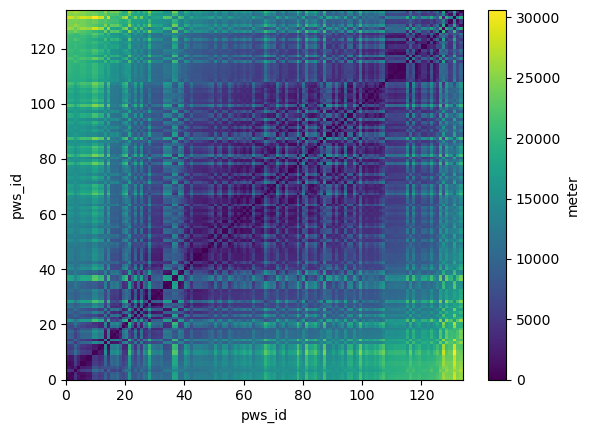

In [38]:
plt.pcolor(distance_matrix.values)
plt.colorbar(label='meter')
plt.xlabel('pws_id')
plt.ylabel('pws_id')

### Calculate data variables 
Next, we will calculate the data variables `nbrs_not_nan` and `reference` that are needed to perform the quality control.

`nbrs_not_nan`:
Number of neighbours within a specificed range `max_distance` around the station that are reporting rainfall for each time step. The selected range depends on the use case and area of interest. In this example we use 10'000 meters. 

 `reference`:
Median rainfall of all stations within range `max_distance` from each station.

In [23]:
max_distance = 10e3
ds_pws = ds_pws.load()

In [26]:
nbrs_not_nan = []
reference = []

for pws_id in tqdm(ds_pws.id.data):
    neighbor_ids = distance_matrix.id.data[
        (distance_matrix.sel(id=pws_id) < max_distance)
        & (distance_matrix.sel(id=pws_id) > 0)
    ]

    N = ds_pws.rainfall.sel(id=neighbor_ids).isnull().sum(dim="id")
    nbrs_not_nan.append(N)

    median = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")
    reference.append(median)

ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="id")
ds_pws["reference"] = xr.concat(reference, dim="id")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:17<00:00,  7.49it/s]


CPU times: user 14.5 s, sys: 3.6 s, total: 18.1 s
Wall time: 18 s


### Load reference data set
As referecence data for the indicator correlation filter (so called primary stations, c.f. Bárdossy et al. (2021)), 20 time series from pixels from the gauge-adjusteed KNMI radar product over the Amsterdam Metropolitan area were chosen randomly.

The following cell loads this data set and adds cartesian coordinates as shown above

In [27]:
ds_ref = xr.open_dataset("pypwsqc/docs/notebooks/data/RadarRef_AMS.nc")

In [28]:
ds_ref.load()
ds_ref.coords["x"], ds_ref.coords["y"] = plg.spatial.project_point_coordinates(
    ds_ref.lon,
    ds_ref.lat,
    target_projection="EPSG:25832",
)

## Exercise 1
1.1 Plot some time series of PWS and reference data  
1.2 Calculate the distance between PWS and reference data  
1.3 Plot an approximate and a widely seperated pair of PWS-refernce data

## Faulty Zero Filter (FZ)
Conditions for raising Faulty Zeros flag:

* Median rainfall of neighbouring stations within range `max_distance` is larger than zero for at least `nint` time intervals while the station itself reports zero rainfall.
* The FZ flag remains 1 until the station reports nonzero rainfall.
* Filter cannot be applied if less than `nstat` neighbours are reporting data (FZ flag is set to -1)

For settings for parameter `nint` and `nstat`, see table 1 in [de Vos et al. (2021)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731)

In [41]:
%%time
# compute filter
fz_flag = pypwsqc.flagging.fz_filter(
    pws_data=ds_pws.rainfall,
    nbrs_not_nan=ds_pws.nbrs_not_nan,
    reference=ds_pws.reference,
    nint=3,
    n_stat=5,
)

#add flag to ds_pws
ds_pws["fz_flag"] = fz_flag

CPU times: user 2min 37s, sys: 149 ms, total: 2min 37s
Wall time: 2min 37s


In [ ]:
 pypwsqc.flagging.fz_filter(

## High Influx Filter (HI)
Conditions for raising High Influx flag:

* If median below threshold `ϕA`, then high influx if rainfall above threshold `ϕB`
* If median above `ϕA`, then high influx if rainfall exceeds median times `ϕB`/`ϕA`
* Filter cannot be applied if less than `nstat` neighbours are reporting data (HI flag is set to -1)

For settings for parameter `ϕA`, `ϕB` and `nstat`, see table 1 in [de Vos et al. (2021)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731)

In [43]:
%%time
# compute filter
hi_flag = pypwsqc.flagging.hi_filter(
    pws_data=ds_pws.rainfall,
    nbrs_not_nan=ds_pws.nbrs_not_nan,
    reference=ds_pws.reference,
    hi_thres_a=0.4,
    hi_thres_b=10,
    n_stat=5,
)

#add flag to ds_pws
ds_pws["hi_flag"] = hi_flag

CPU times: user 183 ms, sys: 95 ms, total: 278 ms
Wall time: 275 ms


Check flags in time series

In [ ]:
ds_pws

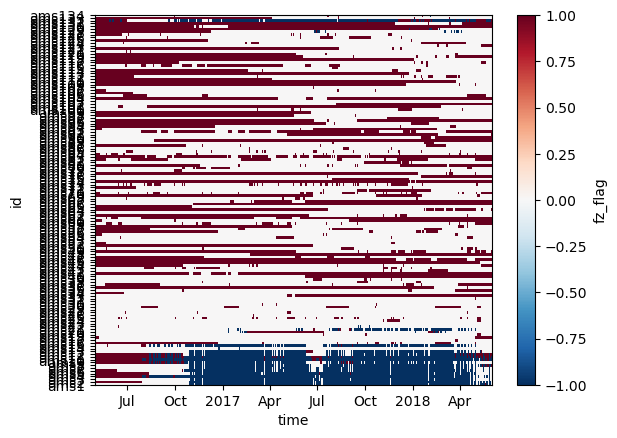

In [47]:
ds_pws.fz_flag.plot();


## Exercise 2
2.1 Vary parameters for FZ
2.2 Vary parameters for HI

## Indicator Correlation Filter (IC)
The PWS data needs to be in hourly values as the indocator correlation filter by Bárdossy et al. (2021) does not work with 5 minute data

For the aggreation, the new value for an hour is considered as valid if at least 10 out 12 5-min values within one hour have valid data. This can be set by the min count parameter.

In [56]:
ds_pws_hourly = ds_pws.resample(time="1h").sum(min_count=10)


/home/mgraf/miniforge3/envs/opensense_ts/lib/python3.11/site-packages/xarray/groupers.py:487: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


### Indicator correlation vs distance
First, we calculate the indicator correlations over distance for the reference data set. This is assumed to be the correct spatial pattern of precipitation which is used for checking the PWS later on.

In [50]:
import pypwsqc.indicator_correlation as ic


In [51]:
# Distance and indicator correlations of reference data
dist_mtx_ref, indcorr_mtx_ref = ic.indicator_distance_matrix(
    ds_ref.rainfall,
    ds_ref.rainfall,
    max_distance=30e3,
    prob=0.99,
    min_valid_overlap=2 * 24 * 30,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.31it/s]


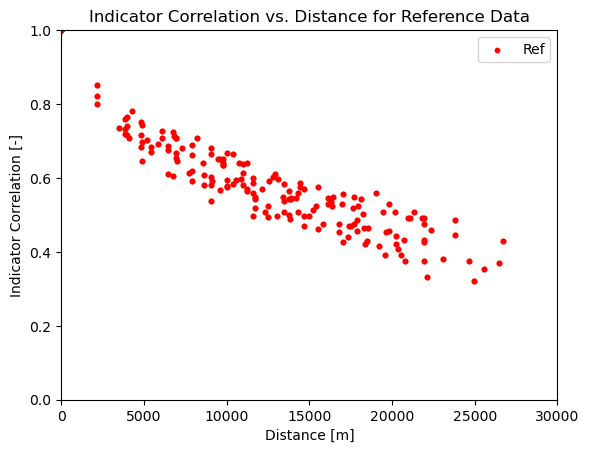

In [53]:
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color="red", s=10, label="Ref")
plt.ylim(0, 1)
plt.xlim(0, 30e3)
plt.ylabel("Indicator Correlation [-]")
plt.xlabel("Distance [m]")
plt.title("Indicator Correlation vs. Distance for Reference Data")
plt.legend();

In [57]:
# Distance and indicator correlations of PWS
dist_mtx_pws, indcorr_mtx_pws = ic.indicator_distance_matrix(
    ds_pws_hourly.rainfall,
    ds_pws_hourly.rainfall,
    prob=0.99,
    max_distance=30e3,
    min_valid_overlap=2 * 24 * 30,
)

/home/mgraf/miniforge3/envs/opensense_ts/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide    | 0/134 [00:00<?, ?it/s]
  c /= stddev[:, None]
/home/mgraf/miniforge3/envs/opensense_ts/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:51<00:00,  2.61it/s]


''

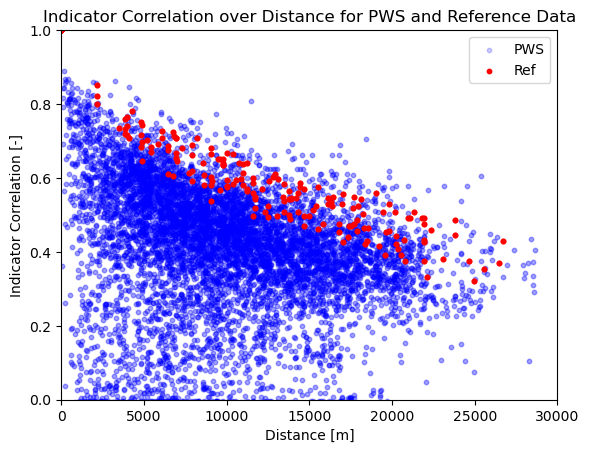

In [58]:
plt.scatter(dist_mtx_pws, indcorr_mtx_pws, color="b", alpha=0.2, s=10, label="PWS")
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color="red", s=10, label="Ref")
plt.ylim(0, 1)
plt.xlim(0, 30e3)
plt.ylabel("Indicator Correlation [-]")
plt.xlabel("Distance [m]")
plt.title("Indicator Correlation over Distance for PWS and Reference Data")
plt.legend()
;

We can see that the PWS data is very "noisy", i.e. the indicator correlation of nearby PWS stations is very low which we would not expect from the reference. Such PWS are likely to have data quality issues ans will be removed by the Indicator Correlation Filter.

Finally the distance and indicator correlations matrices between PWS and reference data are calculated.

In [59]:
dist_mtx_ref_pws, indcorr_mtx_ref_pws = ic.indicator_distance_matrix(
    da_a=ds_ref.rainfall,
    da_b=ds_pws.rainfall,
    prob=0.99,
    min_valid_overlap=2 * 24 * 30,
)

/home/mgraf/miniforge3/envs/opensense_ts/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide     | 0/20 [00:00<?, ?it/s]
  c /= stddev[:, None]
/home/mgraf/miniforge3/envs/opensense_ts/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06it/s]


### Apply filter

In [64]:
indcorr_results = ic.ic_filter(
    indicator_correlation_matrix_ref=indcorr_mtx_ref,
    distance_correlation_matrix_ref=dist_mtx_ref,
    indicator_correlation_matrix=indcorr_mtx_ref_pws,
    distance_matrix=dist_mtx_ref_pws,
    max_distance=20000,
    bin_size=1000,
    quantile_bin_ref=0.1,
    quantile_bin_pws=0.5,
    threshold=0.05,
);

In [61]:
indcorr_results

<xarray.Dataset> Size: 47kB
Dimensions:        (id: 20, id_neighbor: 134)
Coordinates:
  * id             (id) <U2 160B '0' '1' '2' '3' '4' ... '16' '17' '18' '19'
  * id_neighbor    (id_neighbor) <U6 3kB 'ams1' 'ams2' ... 'ams133' 'ams134'
Data variables:
    indcorr        (id, id_neighbor) float64 21kB 0.2786 0.2782 ... 0.213 0.1662
    dist           (id, id_neighbor) float64 21kB 2.41e+04 ... 2.804e+04
    indcorr_good   (id_neighbor) bool 134B False False False ... False False
    indcorr_score  (id_neighbor) float64 1kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

The results are returned as `xarray.Dataset` with four variables:

`indcorr`: Indicator correlation matrix between `Ref` and `PWS`

`dist`: Distance matrix between `Ref` and `PWS`

`indcorr_good`: Bool Array indicating whether a PWS was accepted ('True') or rejected ('False') by the filter

`indcorr_score`: A metric which indicates how well a PWS fit's into the correlation structure of the Reference

## Exercise 3
3.1 Play with threshold  
3.2 Which filters are useful under which cases?  
3.3 Which pws are flagged by which filter?   